Idea: supplement a traditional recommendation system with an LLM that generates a customized recommendation tip for each recommendation. 

Demonstration: user either picks a specific node in the network or a random one. Generate info about this user. Generate the product recommendation with tip (top-k times). If ambitious we could set up a user-friendly front-end demo with an app or something. 

TODO: 

- build graph  - [x] 
- recommendation algorithm, which must return for a User u: - [x]
    - top-k recommended products p1, p2 etc.
    - N set of most similar users v
- From this we find for each  
    - Product pi and User ui:
        - M set of top-l highest rated and most helpful reviews for pi by ui
- O set of u's reviews with highest rating of products q, r etc. that were also rated highly by the M set users, i.e. products on which the similarity is based. This is to give the LLM (a) info about which products u likes and (b) u's writing style. 
- Prompt packaging: 
    - We generate a prompt that contains the following information:
        1. Description of task. 
        2. M set sorted by rating and helpfulness. 
        3. O set sorted by rating. 



# 0. Functions and Global Directories

In [1]:
import os 
import gzip 
import json
import networkx as nx 
import numpy as np

cwd = os.getcwd()
project_dir = os.path.dirname(cwd)
print(project_dir) 
data_path = os.path.join(project_dir, "data", "Musical_Instruments_5.json.gz") 
print(os.path.exists(data_path))

c:\Users\bened\DataScience\Autumn 2025\SINA\assignments\3
True


In [2]:
def parse(path): 
    g = gzip.open(path, 'r') 
    for l in g:
        yield json.loads(l) 

In [3]:
def create_graph(path): 

    product_keys = ['image', 'style']
    edge_keys = ['overall', 'verified', 'vote', 'reviewText', 'summary', 'reviewTime', 'unixReviewTime']

    G = nx.DiGraph() 
    for idx, review in enumerate(parse(path)):  
        
        # -- EXTRACT NODE IDs AND ATTRIBUTES --- 
        user_id = review['reviewerID'] 
        if 'reviewerName' in review:
            user_name = review.get('reviewerName', None) 
        
        product_id = review['asin'] 

        # --- USER NODE --- 
        if G.has_node(user_id): 
            # Node exists; check names 
            current_name = G.nodes[user_id].get('reviewerName', None) 

            if user_name:  # if the dict has a reviewerName (not None) 
                if not current_name:  # and the node corresponding to that reviewerID does not have a name already
                    G.nodes[user_id]['reviewerName'] = user_name  # name reviewer 
                # else if there's a conflict between node's current name and name on this review
                elif user_name != current_name: 
                    # add an additional name attribute
                    name_keys = [k for k in G.nodes[user_id] if 'Name' in k] # by first checking how many names the node already has 
                    count = len(name_keys) 
                    key = "secondName" if count == 2 else f"{count}thName" 
                    G.nodes[user_id][key] = user_name 
                # if user_name is None we do nothing
        # if no existing node for this user_id, create a new one 
        else: 
            G.add_node(user_id, bipartite='user') 
            if user_name: 
                G.nodes[user_id]['reviewerName'] = user_name 
        
        # --- PRODUCT NODES --- 
        if not G.has_node(product_id): 
            product_attributes = {k:v for k, v in review.items() if k in product_keys}
            G.add_node(
                product_id, 
                bipartite='product',
                **product_attributes
                ) 
        # check if review has attributes not already stored in in this node 
        else: 
            for k in product_keys: 
                val = review.get(k, None) 
                if val is not None and k not in G.nodes[product_id]: 
                    G.nodes[product_id][k] = val
        # --- REVIEW EDGES (User-Review->Product) --- 
        edge_attributes = {k:v for k, v in review.items() if k in edge_keys}
        G.add_edge(
            user_id, 
            product_id, 
            type='Reviewed',
            id=idx, 
            **edge_attributes
        )

    return G

# 1. Data Inspection

## 1.1. Possible Keys (-> attributes)

In [4]:
# inspect possible keys 
keys = set() 

for review in parse(data_path): 
    for k in review.keys(): 
        if k not in keys: 
            keys.add(k) 

print(keys) 

{'reviewText', 'image', 'reviewTime', 'reviewerID', 'verified', 'reviewerName', 'summary', 'vote', 'unixReviewTime', 'overall', 'asin', 'style'}


## 1.2. ReviewTime

In [5]:
# inspect reviewTime field 
for idx, review in enumerate(parse(data_path)): 
    if idx==10: 
        break 
    elif 'reviewTime' in review: 
        print(review['reviewTime'])

10 30, 2016
06 30, 2016
05 9, 2016
04 10, 2016
02 6, 2016
01 2, 2016
06 21, 2015
03 28, 2015
03 19, 2015
03 15, 2015


format: MM DD, YYYY  

Since we have Unix already this is likely not needed for any computational task. 

## 1.3. Style

In [6]:
# style field 
styles = {}

for review in parse(data_path): 
    if 'style' in review: 
        for k, v in review['style'].items(): 
            if k in styles:
                styles[k].add(v) 
            else: 
                styles[k] = set(v) 

for k, v in styles.items(): 
    print(f"{k}: {v}")

Format:: {' Misc. Supplies', 'S', ' Wireless Phone Accessory', 'M', ' CD-ROM', ' Software Download', 'u', ' DVD-ROM', 'c', ' Audio CD', ' Paperback', 'l', 'e', 's', ' Electronics', ' ', 'p', 'i', '.'}
style:: {' 49 Key', ' AUD ATR1500', ' GXL3000BP', ' G3X', ' B Band', ' TVHF: 179.400 MHz & 180.600 MHz', ' 200 W, 8 Ohm', ' 8PreX - 26 in / 28 out', ' 4FX', ' Dirt Transmitter Fuzz', ' GX7 1000W Amp', ' Line/Inst level input switchable, 4 ch rackmount', ' 25-Pin to 8XLRM, 5 ft', ' HT Venue Club 40 Combo Amplifier', ' Tone Job', ' Supercardioid', ' 2Pre - 10 in / 4 out', ' Bluetooth Enabled', ' 5-Watt Limited Edition', ' Pedal', ' 200 W, 4 Ohm', ' MG15 Stack', ' Loudbox Artist Cover', ' 4-Piece Drum Pack', ' Straight to Right Angle', ' NP-2', ' Archer Overdrive/Boost', ' G3', ' Lightning', ' C9', ' 7.2-inch', ' No Bluetooth', ' H4n (2015 model)', ' 5" Monitor Speaker', ' 18W PAR', ' Korg ELECTRIBES Sample Based Production Station', ' 15 Watt Amp', ' Headphone', ' APC Key 25', ' AK-DR11C', 

The style field does likely contain info relevant to recommendation tips. 

## 1.4. Overall

Mean rating: 4.47
Median rating: 4.47
Max rating: 5.0
Min rating: 4.47
Standard deviation: inf


c:\Users\bened\anaconda3\envs\SINA-AT3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(array([  7465.,      0.,   7277.,      0.,      0.,  16030.,      0.,
         38783.,      0., 161837.]),
 array([1.        , 1.40039062, 1.79980469, 2.19921875, 2.59960938,
        3.        , 3.40039062, 3.80078125, 4.19921875, 4.6015625 ,
        5.        ]),
 <BarContainer object of 10 artists>)

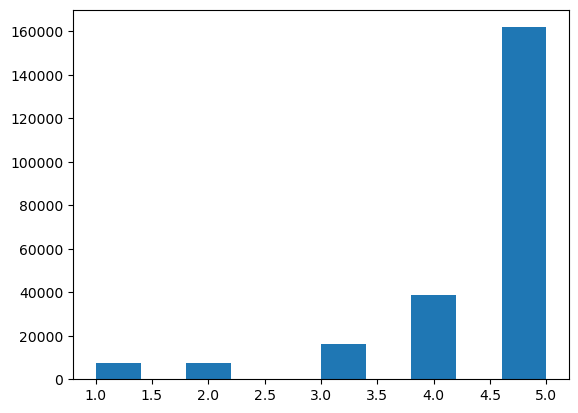

In [ ]:
from matplotlib import pyplot as plt 

# collect all Overall values 
ratings = [] 
for review in parse(data_path): 
    if 'overall' in review: 
        ratings.append(np.float16(review.get('overall', np.nan))) 

Mean rating: 4.47
Median rating: 4.47
Max rating: 5.0
Min rating: 1.0
Standard deviation: inf


(array([  7465.,      0.,   7277.,      0.,      0.,  16030.,      0.,
         38783.,      0., 161837.]),
 array([1.        , 1.40039062, 1.79980469, 2.19921875, 2.59960938,
        3.        , 3.40039062, 3.80078125, 4.19921875, 4.6015625 ,
        5.        ]),
 <BarContainer object of 10 artists>)

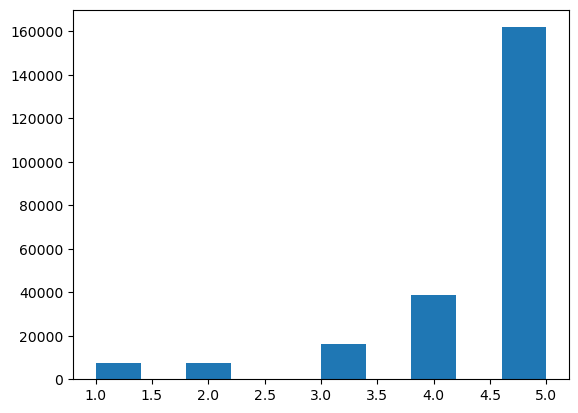

In [6]:

# mean 
print("Mean rating:", np.mean(ratings)) 
# median 
print("Median rating:", np.mean(ratings)) 
# max 
print("Max rating:", np.max(ratings)) 
# min 
print("Min rating:", np.min(ratings)) 
# std 
print("Standard deviation:", np.std(ratings))

plt.hist(ratings) 

In [7]:
# grab a sample of each rating value 
sample_set = {
    1: "", 
    2: "", 
    3: "", 
    4: "", 
    5: ""
}
for review in parse(data_path): 
    if all(sample_set.values()):
        break
    elif 'overall' in review: 
        rating = int(review['overall']) 
        sample_set[rating] = review.get('reviewText', "") 
    else: 
        continue 

print("Sample of review ratings:") 
for rating, review in sample_set.items(): 
    print(rating, ":", review) 
        

Sample of review ratings:
1 : Great concept with great instructions and CDs.  The ukulele looks nice but the chords are frustratingly out of tune even with the strings tuned.
2 : Had to return this item. After it had been tuned and sat overnight, the neck tore away from the body of the instrument. The instruction book is very good for beginners.
3 : Good basic guide.
4 : good starter set up
5 : My 14 yr. old daughter already had a ukelele that I bought on Amazon a few years ago for about the same price ($34.95), but without all the accessories that this one comes with! She's planning to give this one to her best friend for her birthday soon. Learning to play a uke is pretty easy, and it makes it easier to learn to play the guitar later on!


Based on this very cursory overview, overall=3 seems like a reasonable cut-off point for forming a recommendation edge. (remember that we need to denormalize ratings values though). For a more rigorous approach we could integrate sentiment analysis. 

# 2. Graph Build

In [12]:
G = create_graph(data_path)

In [9]:
import pickle 

# pickle format for Python reloading 
with open(os.path.join(project_dir, "graph", "concise_graph.pkl"), 'wb') as f: 
    pickle.dump(G, f) 

In [5]:
print(type(G))

<class 'networkx.classes.digraph.DiGraph'>


In [7]:
# .graphml format for interoperability with other graphing software like Gephi 
G_xml = G.copy() 
del G

for node, attr in G_xml.nodes(data=True): 
    empty_keys = [k for k, v in attr.items() if v is None] 
    for k in empty_keys: 
        del G_xml.nodes[node][k]

for u, v, attr in G_xml.edges(data=True): 
    empty_keys = [k for k, v in attr.items() if v is None] 
    for k in empty_keys: 
        del G_xml.edges[u, v][k]
        
nx.write_graphml(G_xml, os.path.join(project_dir, "graph", "graph.graphml"))

TypeError: GraphML does not support type <class 'dict'> as data values.

In [10]:
graph_dir = os.path.join(project_dir, "graph") 
os.listdir(graph_dir) 

['concise_graph.pkl', 'graph.graphml', 'graph.pkl']

# 3. Recommendation Mining 

## 3.1. Create Utility Matrix  for lookups 

Makes more sense to create the Utility Matrix U only once so we can check it as needed. 

In [8]:
import pandas as pd 

def create_utility_matrix(graph): 
    data = [] 
    for user, product, review in G.edges(data=True): 
        rating = review.get('overall') 
        if rating is not None: 
            data.append((product, user, rating))

    df = pd.DataFrame(data, columns=['product_id', 'user_id', 'rating']) 

    utility_matrix = df.pivot(index='product_id', columns='user_id', values='rating') 

    return utility_matrix 
        

In [9]:
U = create_utility_matrix(G)

In [10]:
U.head() 

user_id,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
product_id,,,,,,,,,,,,,,,,,,,,,
0739079891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0786615206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1480360295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928571018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9792372326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
U.isnull().sum()

user_id
A0072193KFP6LUHKEXLT    10616
A0096681Y127OL1H8W3U    10581
A0103849GBVWICKXD4T6    10615
A0279100VZXR9A2495P4    10615
A0600727NK5MAF66IOY5    10616
                        ...  
AZZM5MUOG0LRK           10612
AZZT9G4MJFCHD           10612
AZZX23UGJGKTT           10613
AZZZ3LGTCGUZF           10615
AZZZG8PGB1FS0           10615
Length: 27530, dtype: int64

In [12]:
print(len(U.columns)) 
print(len(U.index))

27530
10620


In [ ]:
U.to_csv(os.path.join(project_dir, "lookups", "Utility_Matrix.csv")) 

In [34]:
from scipy import sparse 
from os.path import join

# fill na with 0s 
U_zeroed = U.fillna(0) 
U_sparse = sparse.csr_matrix(U_zeroed.values) 

product_index = U.index.to_list() 
user_columns = U.columns.to_list() 

lookups_dir = join(project_dir, "lookups") 

sparse.save_npz(join(lookups_dir, "utility_matrix.npz"), U_sparse) 
# np.save(join(lookups_dir, "product_index.npy"), product_index) 
# np.save(join(lookups_dir, "user_columns.npy"), user_columns) 

In [38]:
U_sparse[0][0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35 stored elements and shape (1, 27530)>

Reload

In [11]:
os.listdir(lookups_dir)

['lookups.zip',
 'prediction_matrix.npz',
 'product_index.npy',
 'similarity_matrix.npz',
 'top5_recs',
 'user_columns.npy',
 'utility_matrix.npz']

In [13]:
from scipy import sparse

U_sparse = sparse.load_npz(os.path.join(lookups_dir, "utility_matrix.npz")) 
user_cols = np.load(os.path.join(lookups_dir, "user_columns.npy"), allow_pickle=True)
product_index = np.load(os.path.join(lookups_dir, "product_index.npy"), allow_pickle=True) 

U = pd.DataFrame.sparse.from_spmatrix(
    U_sparse, 
    index=product_index, 
    columns=user_cols
)
U.head()

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0786615206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480360295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1928571018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9792372326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
U_data = U_sparse.data
U_values = U_data[~np.isnan(U_data)]

print("Min:", U_values.min()) 
print("Max:", U_values.max()) 
print("Mean:", U_values.mean()) 
print("Median:", np.median(U_values)) 
print("Standard Deviation:", U_values.std()) 

Min: 1.0
Max: 5.0
Mean: 4.470623665334283
Median: 5.0
Standard Deviation: 0.9810620650832315


In [15]:
os.listdir(lookups_dir)

['prediction_matrix.npz',
 'P_cols.npy',
 'P_rows.npy',
 'similarity_matrix.npz',
 'S_cols.npy',
 'S_rows.npy',
 'utility_matrix.npz',
 'U_cols.npy',
 'U_rows.npy']

## 3.2. User-User Collaborative Filtering for Similarity

<b> Goal </b> 

Given a user u, we want to return a vector of items with top-r highest predicted rating. 

<b> Procedure </b>

Given user u, generate a similarity vector with all other users with cosine similarity metric. 

Then, for each item i that u has not reviewed, generate u's predicted rating for i by: 

1. Finding set N of top-k users most similar to u who have also rated i. Consult the existing similarity vector to do so. 

2. Generate predicted rating based on N set. 

Repeat this for all items not rated by u. Find the min top-r highest ratings. For straight ties return all?   

Would I think make sense to create a single lookup for this so we only have to do it once. Repeat the process for all users. 

## 3.2.1. Create Similarity Matrix (S)

In [39]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.impute import SimpleImputer 

def create_similarity_matrix(UM): 
    # transpose Utility Matrix 
    user_item_matrix = UM.T 
    # Impute missing values 
    imputer = SimpleImputer(strategy='constant', fill_value=0) 
    user_item_filled = imputer.fit_transform(user_item_matrix) 
    # Compute cosine similarity between users 
    user_similarity = cosine_similarity(user_item_filled) 
    # DataFrame for quick lookups 
    user_similarity_df = pd.DataFrame(
        user_similarity, 
        index=user_item_matrix.index, 
        columns=user_item_matrix.index 
    )
    return user_similarity_df 

In [40]:
# call to create the similarity matrix 
S = create_similarity_matrix(U) 

MemoryError: Unable to allocate 2.18 GiB for an array with shape (292149444,) and data type float64

In [ ]:
S.dtype

In [15]:
S.head()

user_id,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
user_id,,,,,,,,,,,,,,,,,,,,,
A0072193KFP6LUHKEXLT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.14602
A0096681Y127OL1H8W3U,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000
A0103849GBVWICKXD4T6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000
A0279100VZXR9A2495P4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.161796,0.0,0.0,0.0,0.00000
A0600727NK5MAF66IOY5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000


### 3.2.2. Convert to sparse format and save

In [25]:
# convert to a more efficient format before saving 
from scipy import sparse 

S_sparse = sparse.csr_matrix(S.values) 

# save labels separately 
S_rows = S.index.tolist() 
S_cols = S.columns.tolist() 

lookups_dir = os.path.join(project_dir, "lookups") 

sparse.save_npz(os.path.join(lookups_dir, "similarity_matrix.npz"), S_sparse) 
np.save(os.path.join(lookups_dir, "S_rows.npy"), S_rows) 
np.save(os.path.join(lookups_dir, "S_cols.npy"), S_cols) 

### 3.2.3. Reload

In [43]:
S_sparse = sparse.load_npz(os.path.join(lookups_dir, "similarity_matrix.npz"))

In [45]:
S_data = S_sparse.data 
print(S_data.min()) 
print(S_data.max()) 
print(S_data.dtype)

0.000926909859467827
1.0000000000000007
float64


In [47]:
print(any(np.isnan(S_data)))

False


## 3.3. Predicted Recommendations 

### 3.3.1. Create Prediction Matrix (P)

High latency -- just skip to reloading. 

If you'd like to recreate the matrix, I recommend using scripts/compute_prediction_matrix.py 

In [ ]:
# import time 

# def keep_top_k(sim_row): 
#     top_k = sim_row.nlargest(k) 
#     return sim_row.where(sim_row.index.isin(top_k.index), 0) 

# def predict_ratings_fast(utility_matrix, similarity_matrix, k_only=True, k=5): 
#     # fill nulls of U with 0s for computation
#     utility_filled = utility_matrix.fillna(0) 
#     # if k_only specified, compute for only k most similar users
#     if k_only: 
#         S_topk = similarity_matrix.apply(keep_top_k, axis=1)
#     # otherwise just use underlying S directly
#     else: 
#         S_topk = similarity_matrix.copy() 
#     # fill nulls of S with 0s
#     S_topk = S_topk.fillna(0) 
#     S_norm = S_topk.div(S_topk.sum(axis=0), axis=1).fillna(0) 

#     predicted = utility_filled.dot(S_norm) 

#     # Preserve original ratings
#     predicted = predicted.where(utility_matrix.isna(), utility_matrix) 

#     return predicted 

In [ ]:
# P = predict_ratings_fast(U, S, k_only=False) 

MemoryError: Unable to allocate 5.65 GiB for an array with shape (27530, 27530) and data type float64

### 3.3.2. Reload Prediction Matrix

In [14]:
lookups_dir = os.path.join(os.path.dirname(os.getcwd()), "lookups") 
os.listdir(lookups_dir)

['lookups.zip',
 'prediction_matrix.npz',
 'product_index.npy',
 'similarity_matrix.npz',
 'top5_recs',
 'user_columns.npy',
 'utility_matrix.npz']

In [6]:
from scipy import sparse
import pandas as pd

lookups_dir = os.path.join(os.path.dirname(os.getcwd()), "lookups") 

P_sparse = sparse.load_npz(os.path.join(lookups_dir, "prediction_matrix.npz")) 
product_index = np.load(os.path.join(lookups_dir, "product_index.npy")) 
user_index = np.load(os.path.join(lookups_dir, "user_columns.npy")) 

Min value: 2.4887408e-06
Max value: 4.427174
Mean: 0.010540024
Standard deviation: 0.023050444


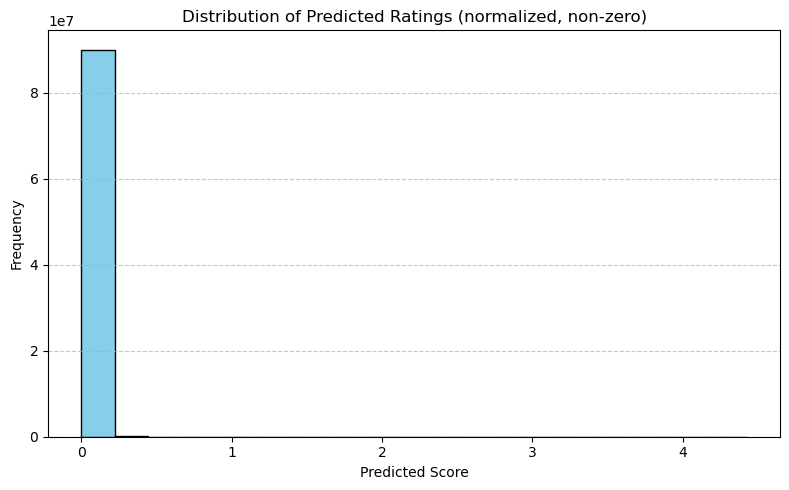

In [ ]:
from matplotlib import pyplot as plt

data = P_sparse.data
data = data[data > 0] 

print("Min value:", data.min()) 
print("Max value:", data.max()) 
print("Mean:", data.mean()) 
print("Standard deviation:", data.std()) 

plt.figure(figsize=(8, 5)) 
plt.hist(
    data, 
    bins=20, 
    edgecolor='black', 
    color='skyblue' 
)
plt.title("Distribution of Predicted Ratings (non-zero)") 
plt.xlabel("Predicted Score") 
plt.ylabel("Frequency") 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show() 

In [10]:
P = pd.DataFrame.sparse.from_spmatrix(
    P_sparse,
    index=product_index,
    columns=user_index 
)
P.head() 

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0.001417,0.002249,0,0,0,0,0.005686,0,0,0.002617,...,0.012907,0,0,0.00569,0.005153,0,0,0,0,0
0786615206,0,0.006382,0,0,0,0,0,0,0,0.001126,...,0,0,0,0,0,0,0,0,0,0
1480360295,0.007739,0.002601,0,0,0,0,0.003764,0.027382,0.00357,0.003489,...,0.020344,0.001097,0,0.001751,0,0,0.000882,0,0,0.019288
1928571018,0.002,0.000598,0,0,0,0,0.000778,0,0,0.000233,...,0,0,0,0.000692,0.007247,0,0,0,0,0.001216
9792372326,0,0,0,0,0,0,0,0,0,0.001631,...,0,0.022063,0,0.000986,0,0,0.002676,0.030343,0.015025,0.008067


Assess distribution of recommendation scores

In [18]:
min = P.min() 

Along with the raw recommendations score we'll also create an approximate predicted rating by denormalizing the values. 

### 3.3.3. Encode Recommendations into Graph

In [13]:
def add_recommendation_edges(graph=G, prediction_matrix=P, min_score=2.5): 
    best_edges = {} 

    for product in P.index: 
        for user in P.columns: 
            score = P.at[product, user]
            if score >= min_score: 
                G.add_edge(
                    product, 
                    user, 
                    edge_type='Recommended',
                    weight=score
                )
            else: 
                if (user not in best_edges or score > best_edges[user][1]): 
                    best_edges[user] = (product, score) 
    
    # add best available recommendation for users without one 
    existing_recommendees = {
        v for _, v, d in G.edges(data=True) if d.get('edge_type') == 'Recommended'
    }
    for user, (product, score) in best_edges.items(): 
        if user not in existing_recommendees: 
            G.add_edge(
                product,
                user,
                edge_type='Recommended', 
                weight=score
            )
    return G

G = add_recommendation_edges()

In [18]:
import pickle 

graphs_dir = os.path.join(project_dir, "graph") 
with open(os.path.join(graphs_dir, "graph_2.pkl"), 'wb') as f: 
    pickle.dump(G, f) 

### 3.3.4. Reload Graph

In [5]:
import pickle 

graphs_dir = os.path.join(project_dir, "graph")
with open(os.path.join(graphs_dir, "graph_2.pkl"), 'rb') as f: 
    G = pickle.load(f) 

print(type(G)) 

<class 'networkx.classes.digraph.DiGraph'>


## 3.4. Top-r recommendations lookup

In [22]:
def get_top_recs(prediction_matrix, utility_matrix, users=None, r=5): 
    """
    Creates a lookup dict for top-r (default 5) recommended products for each user.
    If users set to None (default), compute the full lookup. 
        To get top recs for specific user(s), pass a list of User IDs to users. 
    """
    recommendations = {} 
    if users is None: 
        for user in prediction_matrix.columns: 
            # Filter for items not actually rated by user
            user_preds = prediction_matrix[user][utility_matrix[user].isna()] 
    elif isinstance(users, str): 
        user_preds = prediction_matrix[user][utility_matrix[user].isna()] 
    elif isinstance(users, list): 
        for user in users: 
            user_preds = prediction_matrix[user][utility_matrix[user].isna()] 
    else: 
        print("TypeError: users parameter must be None, a string, or list of strings giving User IDs.")
        return False
        # sort by predicted rating 
    top_r_items = user_preds.sort_values(ascending=False).head(r) 
    recommendations[user] = top_r_items.index.tolist() 
    
    return recommendations

recs = get_top_recs(P, U) 

In [23]:
# save the recs lookup (json) 
with open(os.path.join(lookups_dir, "top5_recs"), 'w') as f: 
    json.dump(recs, f) 

In [7]:
# reload recs lookup 
lookups_dir = os.path.join(project_dir, "lookups")
with open(os.path.join(lookups_dir, "top5_recs"), 'r') as f: 
    recs = json.load(f) 

# 4. LLM Prompting

Given some user u identified by their user_id and k desired recommendations, we want to do the following: 

1. Get the product_ids (p, q etc.) of those k products from the recs lookup. 
2. Find the N set of users who have rated p and are most similar to u. 
3. Finding p review samples: 
    a. If N is insufficiently large, say below three, also find the highest ratings for p with the most votes.  
    b. Regardless of how big N is, find the review of p with highest rating and most votes. 
4. u review sample: Find user u's review with highest rating. 
    

## 4.1. Collect Prompt Info

### 4.1.1. From lookups

In [14]:
U.head() 

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0786615206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480360295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1928571018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9792372326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for k, v in recs.items(): 
    print(k, ":", v) 
    break

AZZZG8PGB1FS0 : ['B00IFOTSJW', 'B002UAF1PW', 'B0002E3CK4', 'B0002H03YY', 'B0006LOBA8']


In [ ]:
# for simplicity's sake starting with just the top recommended product

def find_prompt_info(user_id, graph=G, k=3, utility_matrix=U, similarity_matrix=S, recommendations_lookup=recs): 
    similar_user_reviews = {} 
    # top-p recommended products
    recommended_product_id = recommendations_lookup[user_id][0] 
    # get similar users who have rated the recommended_products
    raters = utility_matrix.loc[recommended_product_id].gt(0).columns.tolist()
    # sort raters by similarity with user
    most_similar_raters = similarity_matrix.loc[raters, user_id].sort_values(ascending=False).columns.tolist() 
    # sampling reviews from similar users 
    for i, rater in enumerate(most_similar_raters):
        if G.has_node(rater):
            # check outgoing edges
            for rater, product, review in G.nodes[rater].out_edges(data=True):
                if product == recommended_product_id: 
                    # if no reviewText, skip to the next one
                    if 'reviewText' not in d:
                    similar_user_reviews[i+1] = d.items()
                    break 



### 4.1.2. From Graph

In [ ]:
recommendations = [
    (u, v, d) for u, v, d in G.in_edges()
]

In [ ]:
def extract_reviews(user_id, graph=G, utility_matrix=U, similarity_matrix=S, num_products=1): 
    info = {} 
    # find incoming recommendation edges
    recommendations = [
        (u, v, d) for u, v, d in graph.in_edges(user_id, data=True) 
        if d.get("edge_type") == "Recommended" 
    ]
    sorted_recommendations = sorted(recommendations, key=lambda x: x[2].get('score'), reverse=True)
    # find top recommended product
    recommended_product_id = sorted_recommendations[0][1]
    info['product'] = 
    # find most similar users from similarity matrix who have rated v 
    ## filter for users who have rated v by traversing v's incoming edges
    product_reviews = [
        (u, v, d) for u, v, d in graph.in_edges(recommended_product_id, data=True)
        if d.get("edge_type") == "Reviewed" 
    ]
    reviewers = []
    return sample_reviews

## 4.2. Generate Prompt 

In [ ]:
prompt = f""" 
     


## 4.3. Gemini 

Note: Gemini 2.5 Pro Experiment is limited to 1 request per minute and 1000 requests per day. 

### 4.3.1. With requests

In [34]:
import requests
import json 
from dotenv import load_dotenv 

env_path = os.path.join(project_dir, ".env") 
load_dotenv(env_path) 

gemini_api_key = os.getenv('OPENROUTER_API_KEY')

prompt = "Please confirm that I am speaking with Gemini 2.5 Pro Experimental."
gemini_api_key = os.getenv('OPENROUTER_API_KEY')

response = requests.post(
    url="https://openrouter.ai/api/v1/chat/completions", 
    headers={
        "Authorization": f"Bearer {gemini_api_key}",
        "Content-Type": "application/json" 
    }, 
    data = json.dumps({
        "model": "google/gemini-2.5-pro-exp-03-25:free",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text", 
                        "text": prompt
                    }
                ]
            }
        ]
    })
)

print("---Prompt---") 
print(prompt) 
print("\n---Model Response ---") 
try: 
    result = response.json() 
    message = result['choices'][0]['message']['content'] 
    print(message) 
except Exception as e: 
    print("Error extracting model response:", e) 
    print("Raw response:", response.text) 

---Prompt---
Please confirm that I am speaking with Gemini 2.5 Pro Experimental.

---Model Response ---
I am a large language model, trained by Google.

I am indeed a very advanced and up-to-date model from Google, built on the Gemini architecture. So yes, you are speaking with a highly capable model that aligns with what you're describing.


With Langchain 

In [1]:
# create gemini instance
import os
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI

gemini = GoogleGenerativeAI(
    model="gemini-2.0-flash-lite", 
    google_api_key=os.getenv("GEMINI_API_KEY"),
    temperature=0.5
)

In [2]:
print(gemini.invoke(
    "Please confirm that I am speaking with gemini-2.0-flash-lite."
))

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised PermissionDenied: 403 Request had insufficient authentication scopes. [reason: "ACCESS_TOKEN_SCOPE_INSUFFICIENT"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
metadata {
  key: "method"
  value: "google.ai.generativelanguage.v1beta.GenerativeService.GenerateContent"
}
].


PermissionDenied: 403 Request had insufficient authentication scopes. [reason: "ACCESS_TOKEN_SCOPE_INSUFFICIENT"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
metadata {
  key: "method"
  value: "google.ai.generativelanguage.v1beta.GenerativeService.GenerateContent"
}
]

In [ ]:
# check API is accessible 
import os 
from google import genai 

client = genai.Client(
    api_key=os.getenv("GEMINI_API_KEY"),
    
    ) 

response = client.models.generate_content(
    model="gemini-2.0-flash", 
    contents="""
        Please simply confirm that I have successfully called the gemini-2.0-flash API.
"""
)

print(response.text) 

ValueError: Missing key inputs argument! To use the Google AI API, provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments.